## Configure tesseract

In [ ]:
import pytesseract
print(pytesseract.get_tesseract_version())
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

5.5.0.20241111


## โหลดรูปเบื้องต้น

In [82]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def closing_image(binary_image):
    kernel = np.ones((5, 5), np.uint8)  # กำหนดขนาด 5x5
    closing = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel, iterations=1)

    return closing

def hough_line_transform(binary_image):

    # แปลงเป็นภาพขาวดำ (Binary)
    edges = cv2.Canny(image, 100, 200, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=200, minLineLength=50, maxLineGap=5)
    
    # วาดเส้นบนภาพต้นฉบับ
    image_color = cv2.cvtColor(binary_image.copy(), cv2.COLOR_GRAY2BGR)  # แปลงเป็นภาพสีเพื่อวาดเส้น

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_color, (x1, y1), (x2, y2), (0, 0, 255), 2)  # วาดเส้นสีแดง
    
    return image_color

def auto_canny(gray_img, sigma=0.33):

    # คำนวณค่า Median ของภาพ
    median_val = np.median(gray_img)

    # ตั้งค่า Threshold อัตโนมัติ
    low_thresh = int(max(0, (1-sigma) * median_val))  # 66% ของ Median
    high_thresh = int(min(255, (1+sigma) * median_val))  # 133% ของ Median

    # ใช้ Canny Edge Detection
    edges = cv2.Canny(gray_img, low_thresh, high_thresh)

    return edges

def morphological_Operations(table_binary_img):

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # ใช้ Closing เพื่อเติมช่องว่างของเส้น
    closed = cv2.morphologyEx(table_binary_img, cv2.MORPH_CLOSE, kernel, iterations=2)
    cv2.imwrite(f"{output_folder}/closed.png", closed)

    table_binary_img = closed.copy()

    # ใช้ Morphological Operations เพื่อเชื่อมเส้นแนวนอน
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    horizontal_lines = cv2.morphologyEx(table_binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # ใช้ Morphological Operations เพื่อเชื่อมเส้นแนวตั้ง
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(table_binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # รวมเส้นแนวนอนและแนวตั้ง
    grid = cv2.add(horizontal_lines, vertical_lines)

    
    # รวมเส้นแนวนอนและแนวตั้ง
    lines_old = cv2.bitwise_or(horizontal_lines, vertical_lines)

    # ใช้ Canny Edge Detection
    edges = cv2.Canny(lines_old, 50, 150)

    # ตรวจจับเส้นด้วย Hough Transform
    lines = cv2.HoughLinesP(lines_old.copy(), 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

    # วาดเส้นที่ตรวจจับได้
    output = cv2.cvtColor(table_binary_img, cv2.COLOR_GRAY2BGR)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Combine lines
    combined_lines = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)

    # เติมเส้นตารางที่ขาดด้วย Dilation
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(grid, kernel, iterations=1)
    cv2.imwrite(f"{output_folder}/table_morphological.png", grid)
    cv2.imwrite(f"{output_folder}/lines.png", lines_old)
    cv2.imwrite(f"{output_folder}/edges.png", edges)
    cv2.imwrite(f"{output_folder}/combined_lines.png", combined_lines)
    cv2.imwrite(f"{output_folder}/table_dilated.png", dilated)
    cv2.imwrite(f"{output_folder}/output_final.png", output)


output_folder = Path("../data/output_images/output_V6_HS")
output_folder.mkdir(exist_ok=True)

image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/high_school/moe/transcript_hs_moe_f_11.png")
#image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/transcript_hs_front_1.png")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

denoised = cv2.bilateralFilter(image, d=9, sigmaColor=100, sigmaSpace=100) # จำกัด noise
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged = auto_canny(gray_img, 0.33)


# สำหรับภาพที่แสงสม่ำเสมอ
binary_mean = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=41, 
    C=20
)

# สำหรับภาพที่แสงไม่สม่ำเสมอ
binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=51, 
    C=20
)

# ใช้ Otsu Thresholding
_, binary_otsu = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

closing_img = closing_image(binary_gaussian)
hlt_img = hough_line_transform(binary_gaussian)
morphological_Operations(binary_gaussian)

cv2.imwrite(f"{output_folder}/original.png", image)
cv2.imwrite(f"{output_folder}/denoised.png", denoised)
cv2.imwrite(f"{output_folder}/gray.png", gray_img)
cv2.imwrite(f"{output_folder}/edged.png", edged)
cv2.imwrite(f"{output_folder}/binary_g.png", binary_gaussian)
#cv2.imwrite(f"{output_folder}/transcript_binary_closing.png", closing_img)
#cv2.imwrite(f"{output_folder}/transcript_hlt_img.png", hlt_img)
#cv2.imwrite(f"{output_folder}/transcript_binary_m.png", binary_mean)
#cv2.imwrite(f"{output_folder}/transcript_otsu.png", binary_otsu)

True

## แยกตารางกับข้อมูลส่วนบน

In [78]:
#import table_detection
#import importlib
#importlib.reload(table_detection)  # รีโหลดไฟล์ใหม่
from skimage.transform import PiecewiseAffineTransform, warp

def split_grade_table_and_students(binary_img, denoised):
    
    # แยกตาราง
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    areas = [stat[4] for stat in stats]  # ดึงค่า area
    sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
    second_max_area = sorted_areas[1]  # ค่าอันดับ 2
    second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม
    table_position = stats[second_max_area_index]
    x, y, w, h, area = table_position
    table_img = binary_img[y:y+h, x:x+w]
    table_original_img = denoised[y:y+h, x:x+w]

    # ข้อมูลนักเรียน
    x_start = int((x+w) * 0.53) # ความกว้าง 50% ของตาราง
    x_end = int((x+w) * 0.74) # ความกว้าง 74% ของตาราง
    student_info_img = binary_img[:y, x_start:x_end]

    return table_img, student_info_img, table_original_img

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        #print(area)
        if area > 1000:
            #print("มา")
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area

    return biggest

def persective_transformation(table_binary_img, table_original_img):

    # ค้นหาคอนทัวร์
    contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # ค้นหาสี่เหลี่ยมที่ใหญ่ที่สุด
    biggest = biggest_contour(contours)

    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points

    # Euclidean Distance Formula
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    rigth_height = np.sqrt(((top_left[0] - bottom_right[0]) ** 2) + ((top_left[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    #max_width = max(int(bottom_width), int(top_width))
    expand_width = round(max(int(bottom_width), int(top_width)) * 0.4)
    max_width = max(int(bottom_width), int(top_width)) + expand_width
    max_height = max(int(rigth_height), int(left_height))

    # Desird points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformaxtion
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_out = cv2.warpPerspective(table_binary_img.copy(), matrix, (max_width, max_height))
    img_original_out = cv2.warpPerspective(table_original_img.copy(), matrix, (max_width, max_height))

    return img_out, img_original_out

def morphological_Operations(table_binary_img):

    # ใช้ Morphological Operations เพื่อเชื่อมเส้นแนวนอน
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    horizontal_lines = cv2.morphologyEx(table_binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # ใช้ Morphological Operations เพื่อเชื่อมเส้นแนวตั้ง
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(table_binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # รวมเส้นแนวนอนและแนวตั้ง
    grid = cv2.add(horizontal_lines, vertical_lines)

    # Combine lines
    combined_lines = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)

    # เติมเส้นตารางที่ขาดด้วย Dilation
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(grid, kernel, iterations=1)
    cv2.imwrite(f"{output_folder}/table_morphological.png", grid)
    cv2.imwrite(f"{output_folder}/combined_lines.png", combined_lines)
    cv2.imwrite(f"{output_folder}/table_dilated.png", dilated)

    '''
    # ค้นหา Contours ของแต่ละช่องในตาราง
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[3], reverse=True)[0:15] # เรียงลำดับ contours ตามค่า h (ความสูง) จากมากไปน้อย

    # คัดกรองเฉพาะ Contours ที่มีขนาดเหมาะสม
    cells = []
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 20 and h > 20:  # ปรับค่าตามขนาดของเซลล์ที่ต้องการจับ
            #print(f"Contour #{i}: bounding box = (x={x}, y={y}, w={w}, h={h})")
            cells.append((x, y, w, h))

    # จัดลำดับช่องจากซ้ายไปขวา และจากบนลงล่าง
    cells = sorted(cells, key=lambda c: (c[1], c[0]))

    # วาดกรอบรอบแต่ละช่องของตาราง
    output = cv2.cvtColor(grid, cv2.COLOR_GRAY2BGR)

    for (x, y, w, h) in cells:
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imwrite(f"{output_folder}/mor.png", output)

    return combined_lines, dilated
    return warped
    '''

def cells_detect(grid_lines):
    # ขั้นตอนที่ 1: Invert ภาพ
    inverted = cv2.bitwise_not(grid_lines) # (เพื่อให้พื้นที่ดำ (ช่องตาราง) กลายเป็นสีขาว, ส่วนเส้นขาวจะเป็นสีดำ)

    # ขั้นตอนที่ 2: Erode พื้นที่ขาวเล็กน้อย เพื่อลดการติดเส้น
    kernel = np.ones((3, 3), np.uint8) # สร้าง kernel เล็ก ๆ เพื่อ erode
    eroded = cv2.erode(inverted, kernel, iterations=0)

    cv2.imwrite(f"{output_folder}/eroded.png", eroded)

    # ขั้นตอนที่ 3: Find Contours (หาพื้นที่สีขาว ซึ่งเป็นรูปทรงของช่องตาราง)
    #contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #filtered_contours = filter(lambda c: cv2.boundingRect(c)[2] > 30, contours)  # กรอง w > 10
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[3], reverse=True)[:10] # เรียงลำดับ contours ตามค่า h (ความสูง) จากมากไปน้อย
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0], reverse=False)  # เรียงลำดับ contours ตามค่า x จากน้อยไปมาก

    # ขั้นตอนที่ 4: วนลูปดูผลลัพธ์ของ Contours แต่ละอัน

    output = cv2.cvtColor(grid_lines.copy(), cv2.COLOR_GRAY2BGR)  # ไว้สำหรับวาดกรอบ
    for i, cnt in enumerate(contours):
        # หา bounding box ของ contour
        x, y, w, h = cv2.boundingRect(cnt)
    
        # วาดสี่เหลี่ยมครอบลงบน output เพื่อดู
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
        print(f"Contour #{i}: bounding box = (x={x}, y={y}, w={w}, h={h})")

    cv2.imwrite(f"{output_folder}/Contours.png", output)

def hough_line_transform(binary_image, table_original_persective_img):

    # 1) ใช้ HoughLinesP ตรวจจับเส้น
    #    - พารามิเตอร์ที่สำคัญ: threshold, minLineLength, maxLineGap
    lines = cv2.HoughLinesP(
        binary_image,
        rho=1,
        theta=np.pi/180,
        threshold=100,      # ต้องปรับจูน
        minLineLength=500,  # ต้องปรับจูน
        maxLineGap=10     # ต้องปรับจูน
    )

    # 2) สร้าง mask (เป็นภาพดำล้วน ขนาดเท่ากับต้นฉบับ)
    line_mask = np.zeros_like(binary_image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # วาดเส้นสีขาวลงใน mask (ปรับ thickness ตามความหนาเส้นในภาพ)
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

    # 4) เราจะเอา mask นี้มาช่วยลบเส้นในภาพ
    #    วิธีง่าย ๆ คือการเอา thresh ที่เป็น binary_inv มาลบด้วย mask (bitwise)
    #    หรืออาจใช้เทคนิค inpaint บนภาพสี

    # วิธีที่ 4.1: ลบตรง ๆ จาก thresh ก่อน (ซึ่งเป็น Binary แล้ว)
    image_without_lines = cv2.bitwise_and(binary_image, cv2.bitwise_not(line_mask))


    # หรือ วิธีที่ 4.2: ลอง inpaint บนภาพจริงสี (img)
    #    โดยปกติ inpaint จะต้องการ mask สีขาว บริเวณที่ต้องการซ่อมแซม
    #    ซึ่ง line_mask ของเราพอดีอยู่แล้ว
    inpainted = cv2.inpaint(table_original_persective_img, line_mask, 3, cv2.INPAINT_TELEA)

    #kernel = np.ones((20, 15), np.uint8)
    #final_dilate = cv2.dilate(image_without_lines, kernel, iterations=1)


    # เนื่องจาก thresh เป็น invert (พื้นดำ ตัวหนังสือขาว)
    # ถ้าอยากกลับด้านให้พื้นขาว ตัวหนังสือดำก็ทำ bitwise_not อีกที
    #final = cv2.bitwise_not(image_without_lines)
    cv2.imwrite(f"{output_folder}/line_mask.png", line_mask)
    cv2.imwrite(f"{output_folder}/image_without_lines.png", image_without_lines)
    #cv2.imwrite(f"{output_folder}/final_dilate.png", final_dilate)
    cv2.imwrite(f"{output_folder}/inpainted.png", inpainted)

    return line_mask


table_img, student_info_img, table_original_img = split_grade_table_and_students(binary_gaussian, denoised)

table_persective_img, table_original_persective_img = persective_transformation(binary_gaussian, denoised)
#combined_lines, table_dilated = morphological_Operations(table_persective_img)
morphological_Operations(table_persective_img)
line_mask = hough_line_transform(table_persective_img, table_original_persective_img)
cells_detect(line_mask)

cv2.imwrite(f"{output_folder}/table_img.png", table_img)
cv2.imwrite(f"{output_folder}/student_info_img.png", student_info_img)
cv2.imwrite(f"{output_folder}/table_original_img.png", table_original_img)
cv2.imwrite(f"{output_folder}/table_persective_img.png", table_persective_img)
#cv2.imwrite(f"{output_folder}/table_original_persective_img.png", table_original_persective_img)
#cv2.imwrite(f"{output_folder}/table_persective_img.png", table_persective_img)



'''
# แยกตาราง
original_img = image
kernel = np.ones((6, 50), np.uint8)
lines_studentInfo = cv2.dilate(binary_gaussian, kernel, iterations=1)
cv2.imwrite(f"{output_folder}/lines_studentInfo.png", lines_studentInfo)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(lines_studentInfo, connectivity=8)
'''




'''
# วนลูปผ่านแต่ละ component (ข้าม label 0 ซึ่งเป็น background)
for i in range(1, num_labels):
    # ดึงค่า bounding box จาก stats: x, y, width, height, และ area
    x, y, w, h, area = stats[i]
    
    # วาดกรอบสี่เหลี่ยมด้วยสีเขียว หนา 2 พิกเซล
    cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255, 0), 1)
cv2.imwrite(f"{output_folder}/cca.png", original_img)
'''


'''
areas = [stat[4] for stat in stats]  # ดึงค่า area
sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
second_max_area = sorted_areas[1]  # ค่าอันดับ 2
second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม

table_position = stats[second_max_area_index]
x, y, w, h, area = table_position
table_img = binary_gaussian[y:y+h, x:x+w]
cv2.imwrite(f"{output_folder}/table.png", table_img)

# แยกประวัติส่วนตัว
student_info_img = binary_gaussian[:y, :]
student_info_gray = gray_img[:y, :]
student_info_color = original_img[:y, :]
cv2.imwrite(f"{output_folder}/student_info_color.png", student_info_color)

# หารูปโปรไฟล์
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(student_info_img, connectivity=8)
areas = [stat[4] for stat in stats]  # ดึงค่า area
sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
second_max_area = sorted_areas[1]  # ค่าอันดับ 2
second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม

profile_position = stats[second_max_area_index]
x, y, w, h, area = profile_position
profile_img = student_info_img[y:y+h, x:x+w]

# ประวัติส่วนตัวที่เอารูปโปรไฟล์ออก
studentInfo_no_profile_img = student_info_img[:, :x-10]
studentInfo_no_gray = student_info_gray[:, :x-10]
cv2.imwrite(f"{output_folder}/studentInfo_no.png", studentInfo_no_profile_img)
cv2.imwrite(f"{output_folder}/studentInfo_no_gray.png", studentInfo_no_gray)
'''

Contour #0: bounding box = (x=4, y=0, w=2026, h=2106)
Contour #1: bounding box = (x=536, y=116, w=70, h=1989)
Contour #2: bounding box = (x=538, y=10, w=67, h=103)
Contour #3: bounding box = (x=607, y=118, w=74, h=1987)
Contour #4: bounding box = (x=608, y=11, w=592, h=102)
Contour #5: bounding box = (x=682, y=118, w=523, h=1988)
Contour #6: bounding box = (x=1204, y=118, w=76, h=1988)
Contour #7: bounding box = (x=1204, y=12, w=70, h=101)
Contour #8: bounding box = (x=1277, y=12, w=60, h=101)
Contour #9: bounding box = (x=1348, y=1916, w=682, h=192)


'\nareas = [stat[4] for stat in stats]  # ดึงค่า area\nsorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย\nsecond_max_area = sorted_areas[1]  # ค่าอันดับ 2\nsecond_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม\n\ntable_position = stats[second_max_area_index]\nx, y, w, h, area = table_position\ntable_img = binary_gaussian[y:y+h, x:x+w]\ncv2.imwrite(f"{output_folder}/table.png", table_img)\n\n# แยกประวัติส่วนตัว\nstudent_info_img = binary_gaussian[:y, :]\nstudent_info_gray = gray_img[:y, :]\nstudent_info_color = original_img[:y, :]\ncv2.imwrite(f"{output_folder}/student_info_color.png", student_info_color)\n\n# หารูปโปรไฟล์\nnum_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(student_info_img, connectivity=8)\nareas = [stat[4] for stat in stats]  # ดึงค่า area\nsorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย\nsecond_max_area = sorted_areas[1]  # ค่าอันดับ 2\nsecond_max_area_index = areas.index(second_max_a

## จับกลุ่มข้อความใน record

In [77]:
def detect_text_group(dilalated_image, binary_image):

    text_group_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากบนไปลงล่าง (ตามค่า y)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    #sorted_indices = np.argsort(char_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
    #sorted_stats = char_stats[sorted_indices]

    sorted_indices = np.lexsort((char_stats[:, 0], char_stats[:, 1]))  # (x, y)
    sorted_stats = char_stats[sorted_indices]

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00

    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats

        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        if w >= 90 and h >= 20:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            text_group_images.append(cca_img)
            cv2.imwrite(f"{output_folder}/studentInfo/cca_{idx}.jpg", cca_img)
            cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return text_group_images

kernel = np.ones((6, 80), np.uint8)
lines_studentInfo = cv2.dilate(studentInfo_no_profile_img, kernel, iterations=1)
cv2.imwrite(f"{output_folder}/studentInfo/find_lines.png", lines_studentInfo)

text_group_studentInfo_images = detect_text_group(lines_studentInfo, studentInfo_no_profile_img)


NameError: name 'studentInfo_no_profile_img' is not defined

In [5]:
custom_config = r'--oem 3 --psm 7'  # ใช้ OCR Engine Mode และ Page Segmentation Mode ที่เหมาะสม

studentInfo_text_box = []
for idx, text_img in enumerate(text_group_studentInfo_images):
    text = pytesseract.image_to_string(text_img, config=custom_config, lang='tha')
    #plt.figure(figsize=(5, 5))
    #plt.imshow(text_img)
    #plt.imshow(text_img, cmap="gray")
    #plt.title(f"dilated_lines")
    plt.show()
    text_cleaned = text.replace("\n", "")  # ลบ \n ออก
    studentInfo_text_box.append(text_cleaned)
    print(text_cleaned)



รบ.1 ปวส. เล“
ระเบียนแสดงผลการเรียนตามหลักสูตรประกาศนียบัตรวิชาชีพชั้นสูง (ปวส.) พุทธศักราช 2563
ชื่อสถานศึกษา วิทยาลัยเทคนิคเชียงราย
รหัสสถานศึกษา 1357016101
จังหวัด เชียงราย
สถานศึกษาเดิม วิทยาลัยเทคนิคเชียงราย
จังหวัด เชียงราย
รหัสประจําตัว 63301280021
ชื่อ - ชื่อสกุล นายอัมรินทร์ ธรรมกาศ
ระดับการศึกษาที่จบ ประกาศนียบัตรวิชาชีพ
เชื้อซาติ ไทย สัญชาติ ไทย ศาสนา พุทธ
ปีการศึกษาที่จบ 2562
เข้าศึกษาเมื่อ 1 กรกฎาคม 2563
วัน เดือน ปีเกิด 1 สิงหาคม 2544 .
หน่วยกิตที่รับโอน -
เลขประจําตัวประชาชน 1 5799 00931 89 ศุ
ชื่อบิดา      นายจํารัส ธรรมกาศ
หน่วยกิตที่เรียน 103
ชื่อมารดา นางสาวกนกพัชร อื่นคํา
หน่วยกิตที่ได้           83
ระดับคะแนนเฉลี่ยสะสม 3.89
ประเภทวิชา อุตสาหกรรม
ผ่านเกณฑ์การประเมินมาตรฐานวิชาชีพเมื่อ 15 มีนาคม 2565
สาขาวิชา เทคโนโลยีคอมพิวเตอร์
สําเร็จการศึกษาเมื่อ 28 มีนาคม 2565
สาขางาน คอมพิวเตอร์ระบบเครื่อข่าย


## แบ่งส่วนตาราง

In [6]:
def table_cell_detection(table_img):
    # ใช้ Morphological Operations เพื่อตรวจจับเส้น
    #แนวนอน (Rows)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    horizontal_lines = cv2.morphologyEx(table_img, cv2.MORPH_OPEN, horizontal_kernel)

    #แนวตั้ง (Columns)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    vertical_lines = cv2.morphologyEx(table_img, cv2.MORPH_OPEN, vertical_kernel)

    # รวมเส้น
    table_structure = cv2.add(horizontal_lines, vertical_lines)

    # Combine lines
    combined_lines = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)

    # Dilate to connect broken lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_lines = cv2.dilate(combined_lines, kernel, iterations=1)

   # plt.figure(figsize=(15, 15))
    #plt.imshow(dilated_lines, cmap="gray")
    #plt.title(f"dilated_lines")
    #plt.show()

    # Find contours
    contours, _ = cv2.findContours(dilated_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return contours

table_cell_contours = table_cell_detection(table_img)

# ฟังก์ชันสำหรับดึงค่า y (แนวตั้ง) สำหรับการจัดเรียงตามแถว
def get_y_position(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return y

# ฟังก์ชันสำหรับดึงค่า x (แนวนอน) สำหรับการจัดเรียงตามคอลัมน์
def get_x_position(cell):
    x, y, w, h = cell
    return x

# จัดเรียง contours ตามตำแหน่ง y (แนวตั้ง) เพื่อแยกแถว
sorted_contours = sorted(table_cell_contours, key=get_y_position)

# แยกแถว
rows = []
current_row = []
previous_y = -1
for ctr in sorted_contours:
    x, y, w, h = cv2.boundingRect(ctr)
    if(w < 30 and h < 30):
        continue
    if previous_y == -1 or abs(y - previous_y) < 10:  # Same row threshold
        current_row.append((x, y, w, h))
    else:
        # จัดเรียงคอลัมน์ในแถวปัจจุบันตามตำแหน่ง x
        rows.append(sorted(current_row, key=get_x_position))
        current_row = [(x, y, w, h)]
    previous_y = y

# เพิ่มแถวสุดท้าย
if current_row:
    rows.append(sorted(current_row, key=get_x_position))

cell_images = []
for row_index, row in enumerate(rows[1:2]):
    for col_index, cell in enumerate(row):
        x, y, w, h = cell
        #cell_image = table_img[y:y+h, x:x+w]
        cell_img = table_img[y+4:y+h-4, x+4:x+w-4]

        # ตัดขอบออก 5%
        #margin_x = int(w * 0.05)  # คำนวณขอบ 2% ของความกว้าง
        #margin_y = int(h * 0.02)  # คำนวณขอบ 2% ของความสูง
        #cropped_cell_image = cell_image[margin_y:h-margin_y, margin_x:w-margin_x]

        cell_images.append(cell_img)
        print(col_index)
        cv2.imwrite(f"{output_folder}/table/Row_{row_index}_Col_{col_index}.png", cell_img)



0
1
2
3
4
5
6
7
8
9


### จับกลุ่มข้อความในตาราง

In [7]:
def detect_text_group_in_cell(dilalated_image, binary_image, mode, calculate_line_stats=None):
    rgb_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

    text_group_images = []
    
    if(mode == 1):
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

        # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
        char_stats = stats[1:]  # ข้าม Background (index 0)
        sorted_indices = np.argsort(char_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
        sorted_stats = char_stats[sorted_indices]

        # ใช้ Boolean Indexing เพื่อเอา noise ออก 
        sorted_stats = sorted_stats[sorted_stats[:, 4] >= 100]

        calculate_line_stats = []
        
        #หาช่องระยะห่างระหว่างบรรทัดเพื่อนนำไปใช้กับ col ชื่อวิชา
        for idx_stat, stat in enumerate(sorted_stats):
            if idx_stat == (len(sorted_stats)-1):
                print("เข้าเงื่อน",idx_stat)
                x, y, w, h, area = stat
                new_y = round(y-(h/2))
                new_h = round(h+h)
                calculate_line_stats.append([x, new_y, w, new_h, area])
            else:
                #print("index: ",idx_stat)
                current_stat = stat
                next_stat = sorted_stats[idx_stat+1]

                distance = next_stat[1] - current_stat[1]
                line_spacing = distance/current_stat[3]

                if line_spacing > 3 and line_spacing < 7: # เป็นชื่อวิชาที่มีความยาวมากกว่า 1 บรรทัด
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*2.5))
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                elif line_spacing > 7:
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                else:
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])

        calculate_line_stats = np.array(calculate_line_stats)
        #print(idx_stat, current_stat)
        #print(distance, line_spacing)

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00
    text_stats = sorted_stats if mode == 1 else calculate_line_stats
    
    for idx, stats in enumerate(text_stats):  # เริ่มจาก 1 เพราะ 0 คือ background

        x, y, w, h, area = stats

        if area >= 100:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            if mode == 1:
                cca_img = binary_image[y:y+h, x:x+w]
            else:
                cca_img = binary_image[y:y+h, :]
            text_group_images.append(cca_img)
            #cv2.imwrite(f"{output_folder}/table/cca_{idx}.jpg", cca_img)

            # หาขนาดของภาพ (ความกว้างและความสูง)
            image_height, image_width, _ = rgb_image.shape  # ได้ค่า (สูง, กว้าง, ช่องสี)
            cv2.rectangle(rgb_image, (x, y), (image_width, y + h), (0, 255, 0), 1)
    
    if mode == 1:
        return text_group_images, calculate_line_stats, rgb_image
    else:
        return text_group_images, rgb_image

cell_text_group_images = []
for idx_cell, cell_img in enumerate(cell_images):
    kernel = np.ones((5, 15), np.uint8)
    lines_cell = cv2.dilate(cell_img, kernel, iterations=1)
    cv2.imwrite(f"{output_folder}/table/text_group/cell_{idx_cell}.png", lines_cell)
    print("cell_img :", idx_cell)

    if idx_cell == 0 or idx_cell == 5:
        print("mode:", 1)
        text_group_cells, calculate_line_stats, cca_img = detect_text_group_in_cell(lines_cell, cell_img, 1)
    else:
        print("mode:", 2)
        text_group_cells, cca_img = detect_text_group_in_cell(lines_cell, cell_img, 2, calculate_line_stats)

    #text_group_cells, cca_img = detect_text_group_in_cell(lines_cell, cell_img, 1)
    cv2.imwrite(f"{output_folder}/table/text_group/cca_{idx_cell}.jpg", cca_img)
    cell_text_group_images.append(text_group_cells)

cell_img : 0
mode: 1
เข้าเงื่อน 23
cell_img : 1
mode: 2
cell_img : 2
mode: 2
cell_img : 3
mode: 2
cell_img : 4
mode: 2
cell_img : 5
mode: 1
เข้าเงื่อน 18
cell_img : 6
mode: 2
cell_img : 7
mode: 2
cell_img : 8
mode: 2
cell_img : 9
mode: 2


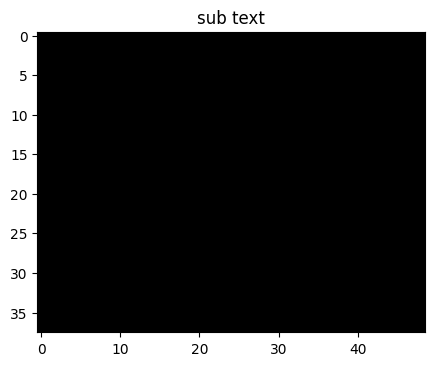

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
ภาพเป็นสีดำทั้งหมด


In [8]:

plt.figure(figsize=(5,5))
plt.imshow(cell_text_group_images[2][10], cmap="gray")
plt.title(f"sub text")
plt.show()
print(cell_text_group_images[2][10])

# เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
if not np.any(cell_text_group_images[2][10]):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
    print("ภาพเป็นสีดำทั้งหมด")
else:
    print("ภาพมีบางส่วนที่ไม่ใช่สีดำ")


### จับข้อความย่อยในกลุ่มข้อความของ cell ตาราง

In [9]:
def detect_text_in_group(binary_image):
    kernel = np.ones((6, 6), np.uint8)
    dummy_image = cv2.dilate(binary_image, kernel, iterations=3)

    '''
    plt.figure(figsize=(5,5))
    plt.imshow(dummy_image, cmap="gray")
    plt.title(f"sub text")
    plt.show()
    '''
    sub_text_images = []

    # เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
    if not np.any(binary_image):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
        print("ภาพเป็นสีดำทั้งหมด")
        sub_text_images.append(binary_image)
        return sub_text_images 
    else:
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

        # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
        char_stats = stats[1:]  # ข้าม Background (index 0)
        sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
        sorted_stats = char_stats[sorted_indices]

        expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
        reduce_size = 0.00
        #for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
        for idx, stats in enumerate(sorted_stats):
            #x, y, w, h, area = stats[i]
            x, y, w, h, area = stats
            x_exp = int(x - (expand_ratio-reduce_size) * w)
            y_exp = int(y - (expand_ratio) * h)
            w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
            h_exp = int(h + 2 * (expand_ratio) * h)

            # ตรวจสอบไม่ให้เกินขอบภาพ
            x_exp = max(0, x_exp)
            y_exp = max(0, y_exp)
            w_exp = min(binary_image.shape[1] - x_exp, w_exp)
            h_exp = min(binary_image.shape[0] - y_exp, h_exp)

            cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            sub_text_images.append(cca_img)
            #cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
            #cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

        return sub_text_images 

cell_text_group_sub_images = []
for idx_cell, cell in enumerate(cell_text_group_images):
    #print("cell ที่ :", idx_cell+1)

    sub_text_cell_images = []
    for idx_text, text_img in enumerate(cell):
        #print("  ข้อความที่ :", idx_text+1)
        sub_text_cell_images.append(detect_text_in_group(text_img))

    cell_text_group_sub_images.append(sub_text_cell_images)



ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด


### จับตัวอักษร

In [54]:
custom_config = r'--oem 3 --psm 7'

def predict_text_in_cell(text_group_sub_images):
    text_box = []
    for idx_group, text_group in enumerate(text_group_sub_images):
        text_sub_text_group = ""
        for idx_sub, sub_text in enumerate(text_group):
            #plt.figure(figsize=(2, 2))
            #plt.imshow(sub_text, cmap="gray")
            #plt.title(f"dilated_lines")
            if not np.any(sub_text):
                print("เข้าเงื่อนไข")
                text = "-"
                '''
                plt.figure(figsize=(5,5))
                plt.imshow(sub_text, cmap="gray")
                plt.title(f"sub text")
                plt.show()
                '''
            else:
                text = pytesseract.image_to_string(sub_text, config=custom_config, lang='tha')
                
            text_sub_text_group += text
            text_cleaned = text_sub_text_group.replace("\n", "")  # ลบ \n ออก
        text_box.append(text_cleaned)
        #print(text_cleaned)

    return text_box

cell_subject_code = cell_text_group_sub_images[0]
cell_subject_name = cell_text_group_sub_images[1]
cell_credit = cell_text_group_sub_images[2]
cell_academic_results = cell_text_group_sub_images[3]
cell_subject_code_2 = cell_text_group_sub_images[5]
cell_subject_name_2 = cell_text_group_sub_images[6]
cell_credit_2 = cell_text_group_sub_images[7]
cell_academic_results_2 = cell_text_group_sub_images[8]

text_box_subject_code = predict_text_in_cell(cell_subject_code)
text_box_subject_name = predict_text_in_cell(cell_subject_name)
text_box_credit = predict_text_in_cell(cell_credit)
text_box_academic_results = predict_text_in_cell(cell_academic_results)
text_box_subject_code_2 = predict_text_in_cell(cell_subject_code_2)
text_box_subject_name_2 = predict_text_in_cell(cell_subject_name_2)
text_box_credit_2 = predict_text_in_cell(cell_credit_2)
text_box_academic_results_2 = predict_text_in_cell(cell_academic_results_2)






เข้าเงื่อนไข
เข้าเงื่อนไข
เข้าเงื่อนไข
เข้าเงื่อนไข


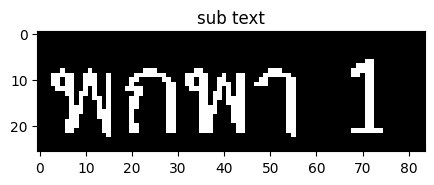

In [45]:
plt.figure(figsize=(5,5))
plt.imshow(cell_subject_name_2[16][1], cmap="gray")
plt.title(f"sub text")
plt.show()

In [55]:
import re

def show_information(array):
    for idx, data in enumerate(array):
        print(data)

def remove_none(my_list):
    while '' in my_list:
        my_list.remove('')
    return my_list

def remove_junk_text(my_list):
    filtered_list = [item for item in my_list if re.search(r'[ก-ฮa-zA-Z0-9]', item)]
    return filtered_list

#show_information(text_box_subject_code)
#show_information(text_box_subject_name)
#show_information(text_box_credit)
#show_information(text_box_academic_results)
#show_information(text_box_subject_code_2)
#show_information(text_box_subject_name_2)
#show_information(text_box_credit_2)
#show_information(text_box_academic_results_2)

show_information(remove_junk_text(text_box_subject_name_2))




ฝึกงาน
กิจกรรมสถานประกอบการ
ภาษาอังกฤษสําหรับการปฏิบัติงาน
การบริหารงานคุณภาพในองค์การ
ดิจิทัลเทคนิค
โปรแกรมโครงสร้าง
การใช้งานไมโครคอนโทรลเลอร์
การเขียนโปรแกรมดอทเน็ต
ระบบเครือข่ายคอมพิวเตอร์
ระบบฐานข้อมูล
การออกแบบและการจัดการเครือข่ายในองค์กร
กิจกรรมองค์การวิชาชีพ 3
ภาษาอังกฤษโครงงาน
ชีวิตกับสังคมไทย
การประยุกต์ใช้โปรแกรมคอมพิวเตอร์กราฟิก
การเขียนโปรแกรมประยุกต์บนเว็บด้วยโปรแกรมสํา
การพัฒนาโปรแกรมประยุกต์บนอุปกรณ์พกพา 1
การเขียนโปรแกรมประยุกต์บนเว็บ
การจัดการระบบปฏิบัติการเครือข่าย  --


In [59]:
combined_list = list(zip(cell_subject_code, cell_subject_name, cell_credit, cell_academic_results))